# Cell Tracking Program
<br><MTMarkdownOptions output='html4'>
    The propose of this project is to develop an algorithm to realize HeLa cell cycle analysis by cell segmentation and cell tracking. Our segmentation algorithm includes binarization, nuclei center detection and nuclei boundary delineating; and our tracking algorithm includes neighboring graph construction, optimal matching, cell division, death, segmentation errors detection and processing, and refined segmentation and matching results. Our chosen testing and training datasets are Histone 2B (H2B)-GFP expressing HeLa cells provided by Mitocheck Consortium. This project used Jaccard index to measure the segmentation accuracy and TRA method for tracking. Our results, respectably 69.51% and 74.61%, demonstrated the validity of the developed algorithm in investigation of cancer cell cycle, the problems and further improvements of our algorithm are also mentioned. 
</MTMarkdownOptions><br><br>

## 0. Prepare Import File and Import Image Set

In [2]:
%matplotlib inline

import os
import cv2
import PIL.Image
import sys
import numpy as np
from IPython.display import Image, display, clear_output
import matplotlib.pyplot as plt

def normalize(image):
    '''
    This function is to normalize the input grayscale image by
    substracting globle mean and dividing standard diviation for
    visualization. 

    Input:  a grayscale image

    Output: normolized grascale image

    '''
    img = image.copy().astype(np.float32)
    img -= np.mean(img)
    img /= np.linalg.norm(img)
    # img = (img - img.min() )
    img = np.clip(img, 0, 255)
    img *= (1./float(img.max()))
    return (img*255).astype(np.uint8)

# read image sequence
# The training set locates at "resource/training/01" and "resource/training/02"
# The ground truth of training set locates at "resource/training/GT_01" and 
# "resource/training/GT_02"
# The testing set locates at "resource/testing/01" and "resource/testing/02"

if sys.argv[1]:
    path=os.path.join("/Users/xrhao/Desktop/resource/training/01")
else:
    path=os.path.join("/Users/xrhao/Desktop/resource/training/01")
for r,d,f in os.walk(path):
    images = []
    enhance_images = []
    for files in f:
        if files[-3:].lower()=='tif':
            temp = cv2.imread(os.path.join(r,files))
            gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) 
            images.append(gray.copy())
            enhance_images.append(normalize(gray.copy()))

print "Total number of image is ", len(images)
print "The shape of image is ", images[0].shape, type(images[0][0,0])

Total number of image is  92
The shape of image is  (700, 1100) <type 'numpy.uint8'>


In [3]:
def display_image(img):
    assert img.ndim == 2 or img.ndim == 3
    h, w = img.shape[:2]
    if len(img.shape) == 3:
        img = cv2.resize(img, (w/3, h/3, 3))
    else:
        img = cv2.resize(img, (w/3, h/3))
    cv2.imwrite("temp_img.png", img)
    img = Image("temp_img.png")
    display(img)

def vis_square(data, title=None):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    # resize image into small size
    _, h, w = data.shape[:3] 
    width = int(np.ceil(1200. / np.sqrt(data.shape[0])))    # the width of showing image 
    height = int(np.ceil(h*float(width)/float(w))) # the height of showing image 
    if len(data.shape) == 4:
        temp = np.zeros((data.shape[0], height, width, 3))
    else:
        temp = np.zeros((data.shape[0], height, width))
    
    for i in range(data.shape[0]):
        if len(data.shape) == 4:
            temp[i] = cv2.resize(data[i], (width, height, 3))
        else:
            temp[i] = cv2.resize(data[i], (width, height))
    
    data = temp
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
              (0, 2), (0, 2))                 # add some space between filters
              + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=255)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    # show image
    cv2.imwrite("temp_img.png", data)
    img = Image("temp_img.png")
    display(img)

def cvt_npimg(images):
    h, w = images[0].shape[:2]
    if len(images[0].shape) == 3:
        out = np.zeros((len(images), h, w, 3))
    else:
        out = np.zeros((len(images), h, w))
    for i, img in enumerate(images):
        out[i] = img
    return out

In [4]:
def write_mask16(images, name, index=-1):
    if index == -1:
        for i, img in enumerate(images):
            if i < 10:
                cv2.imwrite(name+"00"+str(i)+".tif", img.astype(np.uint16))
            elif i >= 10 and i < 100:
                cv2.imwrite(name+"0"+str(i)+".tif", img.astype(np.uint16))
            else:
                cv2.imwrite(name+str(i)+".tif", img.astype(np.uint16))
    else:
        if index < 10:
            cv2.imwrite(name+"00"+str(index)+".tif", images.astype(np.uint16))
        elif index >= 10 and index < 100:
            cv2.imwrite(name+"0"+str(index)+".tif", images.astype(np.uint16))
        else:
            cv2.imwrite(name+str(index)+".tif", images.astype(np.uint16))   

def write_mask8(images, name, index=-1):
    if index == -1:
        for i, img in enumerate(images):
            if i < 10:
                cv2.imwrite(name+"00"+str(i)+".tif", img.astype(np.uint8))
            elif i >= 10 and i < 100:
                cv2.imwrite(name+"0"+str(i)+".tif", img.astype(np.uint8))
            else:
                cv2.imwrite(name+str(i)+".tif", img.astype(np.uint8))
    else:
        if index < 10:
            cv2.imwrite(name+"000"+str(index)+".tif", images.astype(np.uint8))
        elif index >= 10 and index < 100:
            cv2.imwrite(name+"00"+str(index)+".tif", images.astype(np.uint8))
        elif index >= 100 and index < 1000:
            cv2.imwrite(name+"0"+str(index)+".tif", images.astype(np.uint8)) 
        elif index >= 1000 and index < 10000:
            cv2.imwrite(name+str(index)+".tif", images.astype(np.uint8)) 
        else:
            raise

def write_pair8(images, name, index=-1):
    for i, img in enumerate(images):    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        img = cv2.dilate((img*255).astype(np.uint8),kernel,iterations = 3)
        if i < 10:
            cv2.imwrite(name+"00"+str(i)+".tif", img)
        elif i >= 10 and i < 100:
            cv2.imwrite(name+"0"+str(i)+".tif", img)
        else:
            cv2.imwrite(name+str(i)+".tif", img)

## 1. Cell Segmentatioin Part
<br>
<MTMarkdownOptions output='html4'>
    1. Adaptive Thresholding
    <br>
    This file is to compute adaptive thresholding of image sequence in 
    order to generate binary image for Nuclei segmentation.

    Problem:
    Due to the low contrast of original image, the adaptive thresholding is not working. 
    Therefore, we change to regular threshold with threshold value as 129.
</MTMarkdownOptions>


In [15]:
th = None
img = None

class ADPTIVETHRESH():
    '''
    This class is to provide all function for adaptive thresholding.

    '''
    def __init__(self, images):
        self.images = []
        for img in images:
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.images.append(img.copy())

    def applythresh(self, threshold = 129):
        '''
        applythresh function is to convert original image to binary image by thresholding.

        Input: image sequence. E.g. [image0, image1, ...]

        Output: image sequence after thresholding. E.g. [image0, image1, ...]
        '''
        out = []
        markers = []
        binarymark = []

        for img in self.images:
            img = cv2.GaussianBlur(img,(5,5),0).astype(np.uint8)
            thresh = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,31,0)

#             # Using morphlogical operations to imporve the quality of result
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            out.append(thresh)

        return out

def main():
    '''
    This part is for testing adaptivethresh.py with single image.

    Input: an original image

    Output: Thresholding image

    '''
    global th
    global img
    
    adaptive = ADPTIVETHRESH(enhance_images)
    th = adaptive.applythresh(10)
        
# if python says run, then we should run
if __name__ == '__main__':
    main()

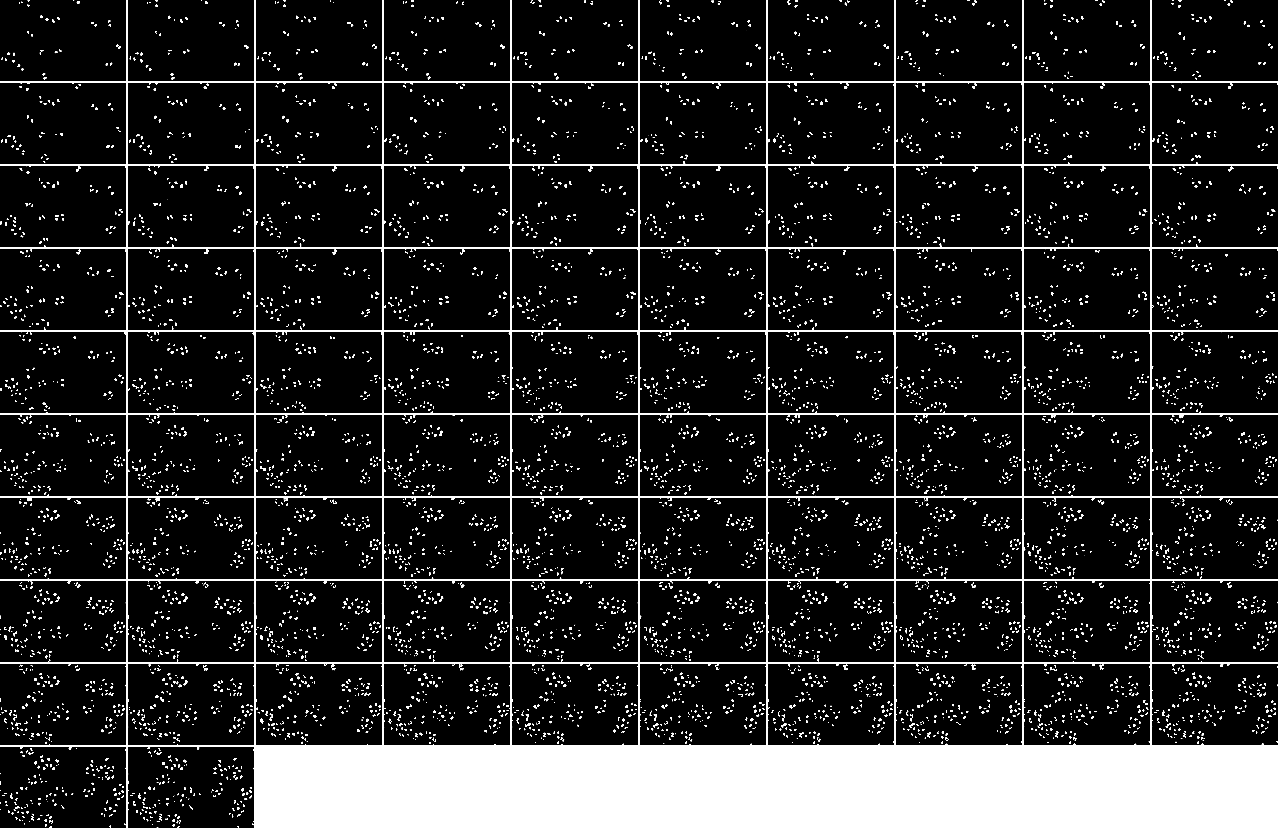

In [16]:
# display images
for i,img in enumerate(th):
    th[i] = img*255
os.chdir("/Users/xrhao/Desktop/resource/result")
write_mask8(th, "thresh")
out = cvt_npimg(th)
vis_square(out)

<br>
<MTMarkdownOptions output='html4'>
    2. Gradient Filed Vector
    <br>
    This file is to compute gradient vector field (GVF) and then find the Nuclei center 
    with the GVF result. 
</MTMarkdownOptions>

In [18]:
from scipy import spatial as sp
from scipy import ndimage
from scipy.spatial import distance

looplimit = 500

newimg = None
pair = None

def inbounds(shape, indices):
    assert len(shape) == len(indices)
    for i, ind in enumerate(indices):
        if ind < 0 or ind >= shape[i]:
            return False
    return True

class GVF():
    '''
    This class contains all function for calculating GVF and its following steps.
    
    '''
    def __init__(self, images, thresh):
        
        self.images = images
        self.thresh = thresh

    def distancemap(self):
        '''
        This function is to generate distance map of the thresh image. We use the opencv
        function distanceTransform to generate it. Moreover, in this case, we use Euclidiean
        Distance (DIST_L2) as a metric of distance. 

        Input: None

        Output: Image distance map

        '''
        return [cv2.distanceTransform(self.thresh[i], distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)\
                for i in range(len(self.thresh))]

    def new_image(self, alpha, dismap):
        '''
        This function is to generate a new image combining the oringal image I0 with
        the distance map image Idis by following expression:
                                Inew = I0 + alpha*Idis
        In this program, we choose alpha as 0.4.

        Input: the weight of distance map: alpha
               the distance map image

        Output: new grayscale image

        '''

        return [self.images[i] + alpha * dismap[i] for i in range(len(self.thresh))]

    def compute_gvf(self, newimage):
        '''
        This function is to compute the gradient vector of the imput image.

        Input: a grayscale image with size, say m * n * # of images

        Output: a 3 dimentional image with size, m * n * 2, where the last dimention is
        the gradient vector (gx, gy)

        '''
        kernel_size = 5 # kernel size for blur image before compute gradient
        newimage = [cv2.GaussianBlur((np.clip(newimage[i], 0, 255)).astype(np.uint8),(kernel_size,kernel_size),0)\
                    for i in range(len(self.thresh))]
        # use sobel operator to compute gradient 
        temp = np.zeros((newimage[0].shape[0], newimage[0].shape[1], 2), np.float32) # store temp gradient image 
        gradimg = []  # output gradient images (height * weight * # of images)

        for i in range(len(newimage)):
            # compute sobel operation in x, y directions
            gradx = cv2.Sobel(newimage[i],cv2.CV_64F,1,0,ksize=3)
            grady = cv2.Sobel(newimage[i],cv2.CV_64F,0,1,ksize=3)
            # add the gradient vector
            temp[:,:,0], temp[:,:,1] = gradx, grady
            gradimg.append(temp)

        return gradimg

    def find_certer(self, gvfimage, index):
        '''
        This function is to find the center of Nuclei.

        Input: the gradient vector image (height * weight * 2).

        Output: the record image height * weight).

        '''
        # Initialize a image to record seed candidates.
        imgpair = np.zeros(gvfimage.shape[:2])

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        dilate = cv2.dilate(self.thresh[index].copy(), kernel, iterations = 1)
        erthresh = cv2.erode(dilate, kernel, iterations = 3)
        while erthresh.sum() > 0:

            print "Image ", index, "left: ", erthresh.sum(), "points"
            # Initialize partical coordinates [y, x]
            y0, x0 = np.where(erthresh>0)
            p0 = np.array([y0[0], x0[0], 1])

            # Initialize record coordicates [y, x]
            p1 = np.array([5000, 5000, 1])

            # mark the first non-zero point of thresh image to 0
            erthresh[p0[0], p0[1]] = 0

            # a variable to record if the point out of bound of image or 
            # out of maximum loop times
            outbound = False

            # count loop times to limit max loop times
            count = 0

            while sp.distance.cdist([p0],[p1]) > 1:

                count += 1
                p1 = p0
                u = gvfimage[p0[0], p0[1], 1]
                v = gvfimage[p0[0], p0[1], 0]
                M = np.array([[1, 0, u],\
                              [0, 1, v],\
                              [0, 0, 1]], np.float32)
                p0 = M.dot(p0)
                if not inbounds(self.thresh[index].shape, (p0[0], p0[1])) or count > looplimit:
                    outbound = True
                    break

            if not outbound:
                imgpair[p0[0], p0[1]] += 1
            clear_output(wait=True)

        return imgpair.copy()

In [10]:
def main():
    '''
    This part is for testing gvf.py with single image.

    Input: an original image

    Output: Thresholding image and seed image

    '''
    global th
    global newimg
    global pair
    # Nuclei center detection
    gvf = GVF(images, th)
    dismap = gvf.distancemap()
    newimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.
    gradimg = gvf.compute_gvf(newimg)
    out = []
    pair = []
    pair_raw = []
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    i = 0
    for i,img in enumerate(gradimg):
        imgpair_raw = gvf.find_certer(img, i)
        pair_raw.append(imgpair_raw)
        neighborhood_size = 20
        data_max = ndimage.filters.maximum_filter(pair_raw[i], neighborhood_size)
        data_max[data_max==0] = 255
        pair.append((pair_raw[i] == data_max).astype(np.uint8))
        os.chdir("/Users/xrhao/Desktop/resource/result")
        write_mask8([pair[i]], "pair_raw", i)
        os.chdir("/Users/xrhao/Desktop")
        y, x = np.where(pair[i]>0)
        points = zip(y[:], x[:])
        dmap = distance.cdist(points, points, 'euclidean')
        y, x = np.where(dmap<10)
        ps = zip(y[:], x[:])
        for p in ps:
            if p[0] != p[1]:
                pair[i][points[min(p[0], p[1])]] = 0
        dilation = cv2.dilate((pair[i]*255).astype(np.uint8),kernel,iterations = 3)
        out.append(dilation)
    
    out = cvt_npimg(out)
    vis_square(out)

# if python says run, then we should run
if __name__ == '__main__':
    main()

Image  0 left:  1332120 points


KeyboardInterrupt: 

<br>
<MTMarkdownOptions output='html4'>
    GVF enhance
    <br>
    This file is to amend the seed points for watershed. 
</MTMarkdownOptions>

In [10]:
from scipy import spatial as sp
from scipy import ndimage
from scipy.spatial import distance

gvf = GVF(images, th)
dismap = gvf.distancemap()
newimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.
# TODO this part is designed to amend the result of gvf. 
pair = []
path=os.path.join("/Users/xrhao/Desktop/resource/result")
for r,d,f in os.walk(path):
    for files in f:
        if files[:5].lower()=='seed':
            print files
            temp = cv2.imread(os.path.join(r,files))
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) 
            y, x = np.where(temp>0)
            points = zip(y[:], x[:])
            dmap = distance.cdist(points, points, 'euclidean')
            y, x = np.where(dmap<10)
            ps = zip(y[:], x[:])
            for p in ps:
                if p[0] != p[1]:
                    temp[points[min(p[0], p[1])]] = 0
            pair.append(temp)
            clear_output(wait=True)
print "finish!"

finish!


<br>
<MTMarkdownOptions output='html4'>
    2*. Distance Map
    <br>
    This file is to distance map to generate the seed points for watershed. 
</MTMarkdownOptions>

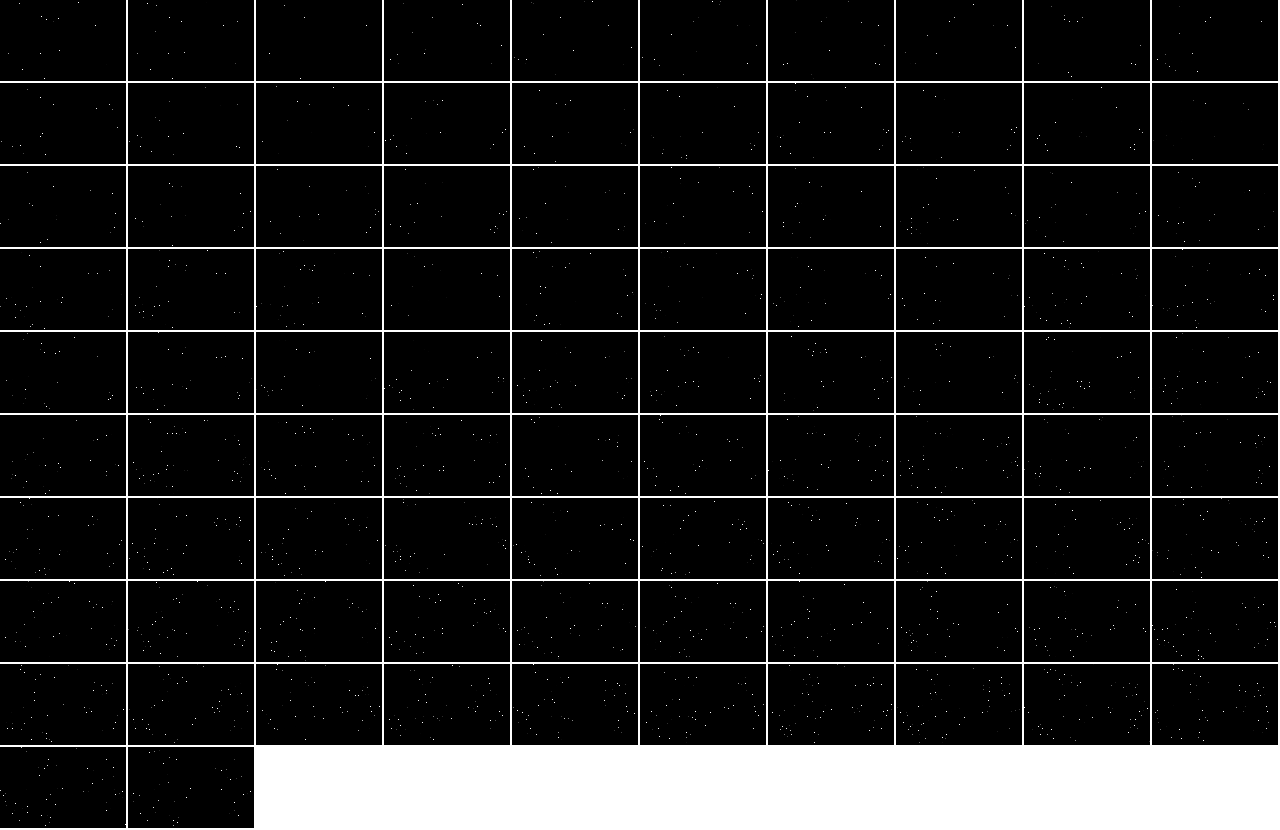

In [19]:
gvf = GVF(images, th)
dismap = gvf.distancemap()
newimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.
out = []
pair = []
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
for i,img in enumerate(dismap):
    neighborhood_size = 20
    data_max = ndimage.filters.maximum_filter(img, neighborhood_size)
    data_max[data_max==0] = 255
    pair.append((img == data_max).astype(np.uint8))
    y, x = np.where(pair[i]>0)
    points = zip(y[:], x[:])
    dmap = distance.cdist(points, points, 'euclidean')
    y, x = np.where(dmap<20)
    ps = zip(y[:], x[:])
    for p in ps:
        if p[0] != p[1]:
            pair[i][points[min(p[0], p[1])]] = 0
    dilation = cv2.dilate((pair[i]*255).astype(np.uint8),kernel,iterations = 1)
    out.append(dilation)
    os.chdir("/Users/xrhao/Desktop/resource/result")
    write_mask8(dilation, "seed_point", i)

out = cvt_npimg(out)
vis_square(out)

<br>
<MTMarkdownOptions output='html4'>
    3. Watershed
    <br>
    This file is to compute watershed given the seed image in the gvf.py.
</MTMarkdownOptions>

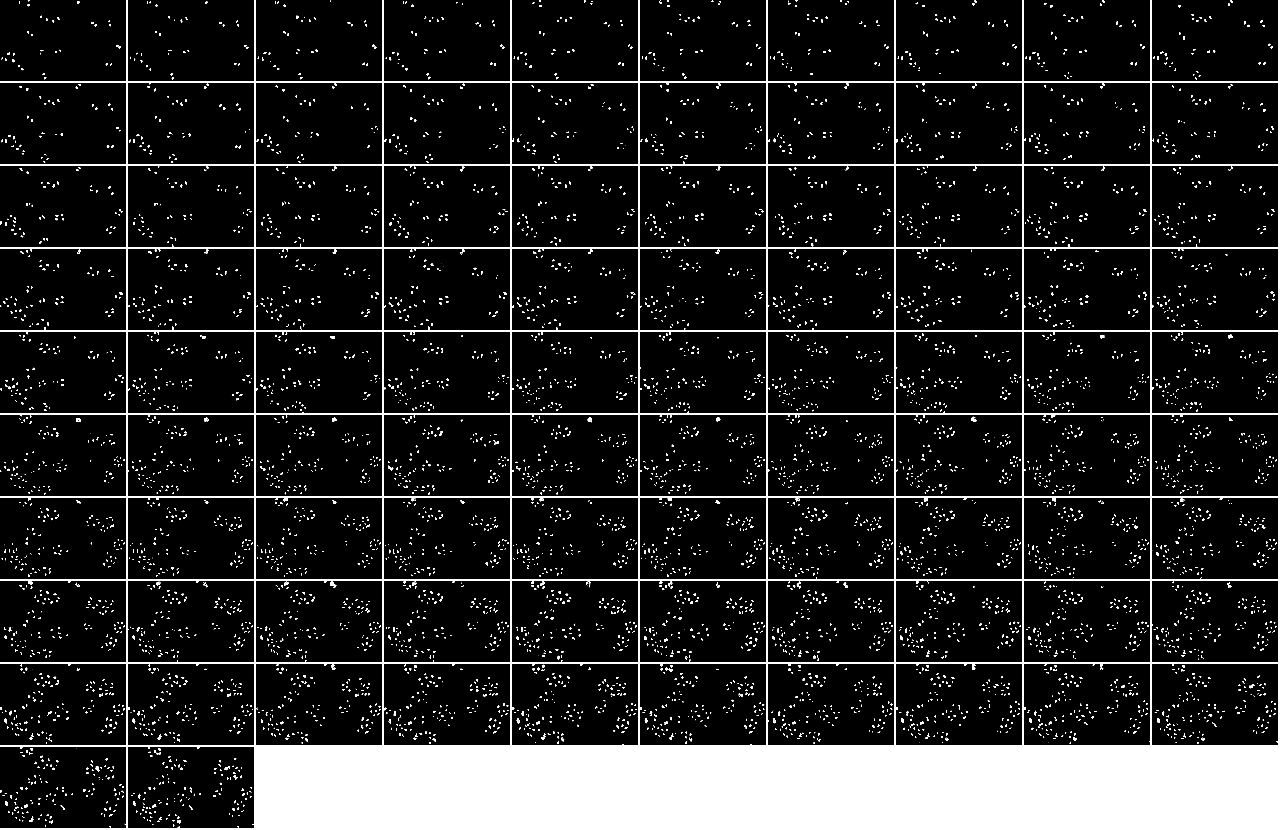

In [8]:
import cv2
import numpy as np
from numpy import unique
import copy as cp

bmarks = None
marks = None

class WATERSHED():
    '''
    This class contains all the function to compute watershed.

    '''
    def __init__(self, images, markers):
        self.images = images
        self.markers = markers

    def is_over_long(self, img, max_lenth=50):
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)
#         print "len: ", len(img[img>0])
        if not len(img[img>0]):
            return True
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        if (rmax-rmin)>max_lenth or (cmax-cmin)>max_lenth:
            return True
        else:
            return False
    
    def watershed_compute(self):
        '''
        This function is to compute watershed given the newimage and the seed image
        (center candidates). In this function, we use cv2.watershed to implement watershed.

        Input: newimage (height * weight * # of images)

        Output: watershed images (height * weight * # of images)

        '''
        result = []
        outmark = []
        outbinary = []

        for i in range(len(self.images)):
            print "image: ", i
            # generate a 3-channel image in order to use cv2.watershed
            imgcolor = np.zeros((self.images[i].shape[0], self.images[i].shape[1], 3), np.uint8)
            for c in range(3): 
                imgcolor[:,:,c] = self.images[i]

            # compute marker image (labelling)
            if len(self.markers[i].shape) == 3:
                self.markers[i] = cv2.cvtColor(self.markers[i],cv2.COLOR_BGR2GRAY)
            _, mark = cv2.connectedComponents(self.markers[i])
            
            # watershed!
            mark = cv2.watershed(imgcolor,mark)
            
            u, counts = unique(mark, return_counts=True)
            counter = dict(zip(u, counts))
            for index in counter:
                temp_img = np.zeros_like(mark)
                temp_img[mark==index] = 255
                if self.is_over_long(temp_img):
                    mark[mark==index] = 0
                    continue
                if counter[index] > 3000:
                    mark[mark==index] = 0
                    continue
            
            labels = list(set(mark[mark>0]))
            length = len(labels)
            temp_img = mark.copy()
            for original, new in zip(labels, range(1,length+1)):
                temp_img[mark==original] = new
            mark = temp_img
                
            # mark image and add to the result 
            temp = cv2.cvtColor(imgcolor,cv2.COLOR_BGR2GRAY)
            result.append(temp)
            outmark.append(mark.astype(np.uint8))

            binary = mark.copy()
            binary[mark>0] = 255
            outbinary.append(binary.astype(np.uint8))
            clear_output(wait=True)

        return result, outbinary, outmark
        
def main():
    '''
    This part is for testing watershed.py with single image.

    Output: Binary image after watershed

    '''
    global bmarks
    global marks
    # watershed
    ws = WATERSHED(newimg, pair) 
#     print len(newimg), len(pair)
    wsimage, bmarks, marks = ws.watershed_compute()
    
    out = cvt_npimg(np.clip(bmarks, 0, 255)).astype(np.uint8)
    vis_square(out)
    os.chdir("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/marks")
    write_mask16(marks, "mask")
    os.chdir("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_RES")
    write_mask8(out, "binary")
#     write_pair8(pair, "pair")
    clear_output(wait=True)
    
# if python says run, then we should run
if __name__ == '__main__':
    main()

<MTMarkdownOptions output='html4'>
    4. Segmentation Evaluation
    <br>
    This file is to evaluate our algorithm about segmentation in jaccard coefficient.
</MTMarkdownOptions>

In [9]:
def list2pts(ptslist):
	list_y = np.array([ptslist[0]])
	list_x = np.array([ptslist[1]])
	return np.append(list_y, list_x).reshape(2, len(list_y[0])).T

def unique_rows(a):
	a = np.ascontiguousarray(a)
	unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
	return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

# read image sequence
# The training set locates at "resource/training/01" and "resource/training/02"
# The ground truth of training set locates at "resource/training/GT_01" and 
# "resource/training/GT_02"
# The testing set locates at "resource/testing/01" and "resource/testing/02"

path=os.path.join("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_GT/SEG")
gts = []
for r,d,f in os.walk(path):
    for files in f:
        if files[-3:].lower()=='tif':
            temp = cv2.imread(os.path.join(r,files), cv2.IMREAD_UNCHANGED)
            gts.append([temp, files[-6:-4]])
print "number of gts: ", len(gts)

# path=os.path.join("test/mark_train_01")
path=os.path.join("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_RES")
binarymarks = []
for r,d,f in os.walk(path):
    for files in f:
        if files[:4]=='mark':
            temp = cv2.imread(os.path.join(r,files))
            gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) 
            binarymarks.append([gray, files[-6:-4]])
print "number of segmentation image: ", len(binarymarks)

jaccards = []

for gt in gts:
	for binarymark in binarymarks:
		if gt[1] == binarymark[1]:
			print "enter...", gt[1]
			list_pts = set(gt[0][gt[0]>0])
			list_seg = set(binarymark[0][binarymark[0]>0])
			# print list_pts, list_seg
			for pt in list_pts:
				for seg in list_seg:
					pts_gt = np.where(gt[0]==pt)
					pts_seg = np.where(binarymark[0]==seg)
					pts_gt = list2pts(pts_gt)
					
					pts_seg = list2pts(pts_seg)
					pts = np.append(pts_gt, pts_seg).reshape(len(pts_gt)+len(pts_seg),2)
					union_pts = unique_rows(pts)

					union = float(len(union_pts))
					intersection = float(len(pts_seg) + len(pts_gt) - len(union_pts))

					if intersection/union > 0.5:
						jaccards.append(intersection/union)
clear_output(wait=True)
jaccard = float(sum(jaccards))/float(len(jaccards))
print "jaccard: ", jaccard, "number of Nuclei: ", len(jaccards)

number of gts:  28
number of segmentation image:  92
enter... 12
enter... 13


KeyboardInterrupt: 

## 2. Cell Tracking Part
<br>
<MTMarkdownOptions output='html4'>
    1. Graph Construction
    <br>
    This file is to generate a neighboring graph contraction using 
    Delaunary Triangulation.
</MTMarkdownOptions>

In [10]:
centroid = None
slope_length = None
class GRAPH():
    '''
    This class contains all the functions needed to compute 
    Delaunary Triangulation.

    '''
    def __init__(self, mark, binary, index):
        '''
        Input: the grayscale mark image with different label on each segments
               the binary image of the mark image
               the index of the image

        '''
        self.mark = mark[index]
        self.binary = binary[index]
              
    def rect_contains(self, rect, point):
        '''
        Check if a point is inside the image

        Input: the size of the image 
               the point that want to test

        Output: if the point is inside the image

        '''
        if point[0] < rect[0] :
            return False
        elif point[1] < rect[1] :
            return False
        elif point[0] > rect[2] :
            return False
        elif point[1] > rect[3] :
            return False
        return True
     
    def draw_point(self, img, p, color ):
        '''
        Draw a point

        '''
        cv2.circle( img, (p[1], p[0]), 2, color, cv2.FILLED, 16, 0 )
     
    def draw_delaunay(self, img, subdiv, delaunay_color ):
        '''
        Draw delaunay triangles and store these lines

        Input: the image want to draw
               the set of points: format as cv2.Subdiv2D
               the color want to use

        Output: the slope and length of each line ()

        '''
        triangleList = subdiv.getTriangleList();
        size = img.shape
        r = (0, 0, size[0], size[1])

        slope_length = [[]]
        for i in range(self.mark.max()-1):
            slope_length.append([])

        for t in triangleList:
             
            pt1 = (t[0], t[1])
            pt2 = (t[2], t[3])
            pt3 = (t[4], t[5])
             
            if self.rect_contains(r, pt1) and self.rect_contains(r, pt2) and self.rect_contains(r, pt3):
                
                # draw lines
                cv2.line(img, (pt1[1], pt1[0]), (pt2[1], pt2[0]), delaunay_color, 1, 16, 0)
                cv2.line(img, (pt2[1], pt2[0]), (pt3[1], pt3[0]), delaunay_color, 1, 16, 0)
                cv2.line(img, (pt3[1], pt3[0]), (pt1[1], pt1[0]), delaunay_color, 1, 16, 0)

                # store the length of line segments and their slopes
                for p0 in [pt1, pt2, pt3]:
                    for p1 in [pt1, pt2, pt3]:
                        if p0 != p1:
                            temp = self.length_slope(p0, p1)
                            if temp not in slope_length[self.mark[p0]-1]:
                                slope_length[self.mark[p0]-1].append(temp)

        return slope_length

    def length_slope(self, p0, p1):
        '''
        This function is to compute the length and theta for the given two points.

        Input: two points with the format (y, x)

        '''
        if p1[1]-p0[1]:
            slope = (p1[0]-p0[0]) / (p1[1]-p0[1])
        else:
            slope = 1e10

        length = np.sqrt((p1[0]-p0[0])**2 + (p1[1]-p0[1])**2)

        return length, slope

    def generate_points(self):
        '''
        Find the centroid of each segmentation

        '''
        centroids = []
        label = []
        max_label = self.mark.max()

        for i in range(1, max_label+1):
            img = self.mark.copy()
            img[img!=i] = 0
            if img.sum():
                _, contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
                m = cv2.moments(contours[0])

                if m['m00']:
                    label.append(i)
                    centroids.append(( int(round(m['m01']/m['m00'])),\
                                       int(round(m['m10']/m['m00'])) ))
                else:
                    label.append(i)
                    centroids.append(( 0,0 ))

        return centroids, label

    def run(self, animate = False):
        '''
        The pipline of graph construction.

        Input: if showing a animation (False for default)

        Output: centroids: # of segments * 2   (y, x)
                slopes and length: # of segments * # of slope_length

        '''
        # Read in the image.
        img_orig = self.binary.copy()
         
        # Rectangle to be used with Subdiv2D
        size = img_orig.shape
        rect = (0, 0, size[0], size[1])
         
        # Create an instance of Subdiv2D
        subdiv = cv2.Subdiv2D(rect);
        
        # find the centroid of each segments
        points, label = self.generate_points()


        # add and sort the centroid to a numpy array for post processing
        centroid = np.zeros((self.mark.max(), 2))
        for p, l in zip(points, label):
            centroid[l-1] = p

        outimg = []
        # Insert points into subdiv
        for p in points:
            subdiv.insert(p)
             
            # Show animation
            if animate:
                img_copy = img_orig.copy()
                # Draw delaunay triangles
                self.draw_delaunay( img_copy, subdiv, (255, 255, 255) );
                outimg.append(img_copy)
                display_image(img_copy)
                clear_output(wait=True)
                
        # Draw delaunay triangles
        slope_length = self.draw_delaunay( img_orig, subdiv, (255, 255, 255) );
     
        # Draw points
        for p in points :
            self.draw_point(img_orig, p, (0,0,255))
        
        # show images
        if animate:
            display_image(img_orig)

        print "length of centroid: ", len(centroid)
        return centroid, slope_length

'''
This part is the small test for graph_contruction.py.

Input:  grayscale marker image
        binary marker image

Output: a text file includes the centroid and the length and slope for each neighbor. 

'''
def main():
    # Build Delaunay Triangulation
    global centroid
    global slope_length
    centroid = []
    slope_length = []
    for i in range(len(images)):
        print "  graph_construction: image ", i
        print "max pixel: ", marks[i].max()
        graph = GRAPH(marks, bmarks, i)
        tempcentroid, tempslope_length = graph.run()
        centroid.append(tempcentroid)
        slope_length.append(tempslope_length)
        clear_output(wait=True)
    print "finish!"

# if python says run, then we should run
if __name__ == '__main__':
    main()

finish!


<MTMarkdownOptions output='html4'>
    2. Matching
    <br>
    This file is to match nuclei in two consecutive frames by Phase Controlled Optimal Matching. 
    It includes two part: 
		1) Dissimilarity measure
		2) Matching
</MTMarkdownOptions>

In [12]:
import imageio
from pyefd import elliptic_fourier_descriptors

Max_dis = 100000

def write_image(image, title, index, imgformat='.tif'):
    if index < 10:
            name = '00'+str(index)
    else:
        name = '0'+str(index)
    cv2.imwrite(title+name+imgformat, image.astype(np.uint16))

class FEAVECTOR():
	'''
	This class builds a feature vector for each segments.
	The format of each vector is: 
					v(k,i) = [c(k,i), s(k, i), h(k, i), e(k, i)], where k is the 
					index of the image (frame) and i is the label of each segment. 

					c(k,i): the centroid of each segment (y, x);
					s(k,i): the binary shape of each segment;
					h(k,i): the intensity distribution (hsitogram) of the segment;
					e(k,i): the spatial distribution of the segment. Its format is 
					like (l(k, i, p), theta(k, i, p)), where p represent different
					line connected with different segment. 

	'''
	def __init__(self, centroid=None, shape=None, histogram=None, spatial=None, \
		               ID=None, start = None, end=None, label=None, ratio=None, area=None, cooc=None):
		self.c = centroid
		self.s = shape
		self.h = histogram
		self.e = spatial
		self.id = ID
		self.start = start
		self.end = end
		self.l = label
		self.a = area
		self.r = ratio
		self.cm = cooc

	def add_id(self, num, index):
		'''
		This function adds cell id for each cell.

		'''
		if index == 0:
			self.id = np.linspace(1, num, num)
		else:
			self.id= np.linspace(-1, -1, num)

	def add_label(self):
		'''
		This function is to add labels for each neclei for post process.

		'''
		self.l = np.linspace(0, 0, len(self.c))

	def set_centroid(self, centroid):
		'''
		This function sets the centroid for all neclei.

		Input: the set of centroid: # of images * # of neclei * 2 (y, x)

		Output: None

		'''
		self.c = centroid

	def set_spatial(self, spatial):
		'''
		This function sets the spatial distrbution for all neclei.

		Input: the set of centroid: # of images * # of neclei * # of line segments (length, slope)

		Output: None

		'''
		self.e = spatial

	def set_shape(self, image, marker):
		'''
		This function sets the binary shape for all necluei.

		Input: the original images: # of images * height * weight
		       the labeled images: # of images * nucei's height * nucei's weight ()

		Output: None

		'''
		def boundingbox(image):
 			y, x = np.where(image)
			return min(x), min(y), max(x), max(y)

		shape = []

		for label in range(1, marker.max()+1):
			tempimg = marker.copy()
			tempimg[tempimg!=label] = 0
			tempimg[tempimg==label] = 1
			if tempimg.sum():
				minx, miny, maxx, maxy = boundingbox(tempimg)
				shape.append((tempimg[miny:maxy+1, minx:maxx+1], image[miny:maxy+1, minx:maxx+1]))
			else:
				shape.append(([], []))

		self.s = shape

	def set_histogram(self):
		'''
		Note: this function must be implemneted after set_shape().

		'''
		def computehistogram(image):
			h, w = image.shape[:2]
			his = np.zeros((256,1))
			for y in range(h):
				for x in range(w):
					his[image[y, x], 0] += 1
			return his

		assert self.s != None, "this function must be implemneted after set_shape()."

		his = []

		for j in range(len(self.s)):
			img = self.s[j][1]
			if len(img):
				temphis = computehistogram(img)
				his.append(temphis)
			else:
				his.append(np.zeros((256,1)))

		self.h = his
    
	def add_efd(self):
		coeffs = []
		for i in range(len(self.s)):
			try:
				_, contours, hierarchy = cv2.findContours(self.s[i][0].astype(np.uint8), 1, 2)
				if not len(contours):
					coeffs.append(0)
					continue
				cnt = contours[0]
				if len(cnt) >= 5:
					contour = []
					for i in range(len(contours[0])):
						contour.append(contours[0][i][0])
					coeffs.append(elliptic_fourier_descriptors(contour, order=10, normalize=False)) 
				else:
					coeffs.append(0)
			except AttributeError:
				coeffs.append(0)
# 		print "ratio: ", len(ratio)
		self.r = coeffs
    
	def add_co_occurrence(self, level=10):
		'''
		This funciton is to generate co-occurrence matrix for each cell. The structure of
		output coefficients is:
		[Entropy, Energy, Contrast, Homogeneity]
		'''
		# generate P metrix.
		self.cm = []
		for j in range(len(self.s)):
			if not len(self.s[j][1]):
				p_0 = np.zeros((level,level))
				p_45 = np.zeros((level,level))
				p_90 = np.zeros((level,level))
				p_135 = np.zeros((level,level))
				self.cm.append([np.array([0, 0, 0, 0]),[p_0, p_45, p_90, p_135]])
				continue
			max_p, min_p = np.max(self.s[j][1]), np.min(self.s[j][1])
			range_p = max_p - min_p
			img = np.round((np.asarray(self.s[j][1]).astype(np.float32)-min_p)/range_p*level)
# 			print img
			h, w = img.shape[:2]
			p_0 = np.zeros((level,level))
			p_45 = np.zeros((level,level))
			p_90 = np.zeros((level,level))
			p_135 = np.zeros((level,level))
			for y in range(h):
				for x in range(w):
					try:
						p_0[img[y,x],img[y,x+1]] += 1
					except IndexError:
						pass
					try:
						p_0[img[y,x],img[y,x-1]] += 1
					except IndexError:
						pass
					try:
						p_90[img[y,x],img[y+1,x]] += 1
					except IndexError:
						pass
					try:
						p_90[img[y,x],img[y-1,x]] += 1
					except IndexError:
						pass
					try:
						p_45[img[y,x],img[y+1,x+1]] += 1
					except IndexError:
						pass
					try:
						p_45[img[y,x],img[y-1,x-1]] += 1
					except IndexError:
						pass
					try:
						p_135[img[y,x],img[y+1,x-1]] += 1
					except IndexError:
						pass
					try:
						p_135[img[y,x],img[y-1,x+1]] += 1
					except IndexError:
						pass
			Entropy, Energy, Contrast, Homogeneity = 0, 0, 0, 0
			for y in range(10):
				for x in range(10):
					if 0 not in [p_0[y,x], p_45[y,x], p_90[y,x], p_135[y,x]]:
						Entropy -= (p_0[y,x]*np.log2(p_0[y,x])+\
									p_45[y,x]*np.log2(p_45[y,x])+\
									p_90[y,x]*np.log2(p_90[y,x])+\
									p_135[y,x]*np.log2(p_135[y,x]))/4
					else:
						temp = 0
						for p in [p_0[y,x], p_45[y,x], p_90[y,x], p_135[y,x]]:
							if p != 0:
								temp += p*np.log2(p)
						Entropy -= temp/4
					Energy += (p_0[y,x]**2+\
								p_45[y,x]**2+\
								p_90[y,x]**2+\
								p_135[y,x]**2)/4
					Contrast += (x-y)**2*(p_0[y,x]+\
										p_45[y,x]+\
										p_90[y,x]+\
										p_135[y,x])/4
					Homogeneity += (p_0[y,x]+\
									p_45[y,x]+\
									p_90[y,x]+\
									p_135[y,x])/(4*(1+abs(x-y)))
# 			print "Entropy: ", Entropy
			self.cm.append([np.array([Entropy, Energy, Contrast, Homogeneity]),[p_0, p_45, p_90, p_135]])

	def add_area(self):
		area = []
		for i in range(len(self.s)):
			area.append(np.count_nonzero(self.s[i][0]))
# 		print "area: ", len(area)
		self.a = area
        
	def generate_vector(self):
		'''
		This function is to convert the vector maxtrics into a list.

		Output: a list of vector: [v0, v1, ....]

		'''
		vector = []
		for i in range(len(self.c)):
				vector.append(FEAVECTOR(centroid=self.c[i],shape=self.s[i],\
                                        histogram=self.h[i],spatial=self.e[i],\
                                        ID=self.id[i],label=self.l[i],\
                                        ratio=self.r[i],area=self.a[i], cooc=self.cm[i]))
		return vector



def set_date(vectors):
	'''
	This function is to add the start and end frame of each vector and
	combine the vector with same id.

	Input: the list of vectors in different frames. 

	Output: the list of vectors of all cell with different id. 

	'''
	max_id = 0
	for vector in vectors:
		for pv in vector:
			if pv.id > max_id:
				max_id = pv.id

# 	print "max_id: ", max_id
	output = np.zeros((max_id, 4))
	output[:,0] = np.linspace(1, max_id, max_id) # set the cell ID
	output[:,1] = len(vectors)
	for frame, vector in enumerate(vectors):
		for pv in vector:
			if output[pv.id-1][1] > frame:     # set the start frame
				output[pv.id-1][1] = frame
			if output[pv.id-1][2] < frame:     # set the end frame
				output[pv.id-1][2] = frame
			output[pv.id-1][3] = pv.l          # set tht cell parent ID

	return output

def write_info(vector, name):
	'''
	This function is to write info. of each vector.

	Input: the list of vector generated by set_date() and 
	       the name of output file.

	'''
	with open(name+".txt", "w+") as file:
		for p in vector:
			file.write(str(int(p[0]))+" "+\
				       str(int(p[1]))+" "+\
				       str(int(p[2]))+" "+\
				       str(int(p[3]))+"\n")
'''
This part is to test the matching scheme with single image

Input: the original image;
       the labeled image;
       the binary labeled image.

'''
vector = None
def main():
	# Feature vector construction
	global centroid
	global slope_length
	global vector
	vector = []
	max_id = 0
	for i in range(len(images)):
# 	for i in range(5):
		print "  feature vector: image ", i
		v = FEAVECTOR()
		v.set_centroid(centroid[i])
		v.set_spatial(slope_length[i])
		v.set_shape(enhance_images[i], marks[i])
		v.set_histogram()
		v.add_label()
		v.add_id(marks[i].max(), i)
		v.add_efd()
		v.add_area()
		v.add_co_occurrence()
		vector.append(v.generate_vector())
		print "num of nuclei: ", len(vector[i])
		clear_output(wait=True)

	print "finish"

# if python says run, then we should run
if __name__ == '__main__':
    main()

finish


This part is to get the sub-image for each cell and save as file. 

In [15]:
os.chdir("/Users/xrhao/Desktop/resource/cells")

image_size = 70
counter = 0
for i, vt in enumerate(vector):
    print "Image: ", i
    for v in vt:
        h, w = v.s[1].shape[:2]
        extend_x = (image_size - w) / 2
        extend_y = (image_size - h) / 2
        temp = cv2.copyMakeBorder(v.s[1], \
                                  extend_y, (image_size-extend_y-h), \
                                  extend_x, (image_size-extend_x-w), \
                                  cv2.BORDER_CONSTANT, value=0)
        write_mask8(temp, "cell_image"+str(i)+"_", counter)
        counter += 1
        clear_output(wait=True)
print "finish!"

finish!


This part is to using ratio of the two axises of inerial as mitosis refinement to mactch cells.

In [380]:
class SIMPLE_MATCH():
	'''
	This class is simple matching a nucleus into a nucleus in the previous frame by 
	find the nearest neighborhood. 

	'''
	def __init__(self, index0, index1, images, vectors):
		self.v0 = cp.copy(vectors[index0])
		self.v1 = cp.copy(vectors[index1])
		self.i0 = index0
		self.i1 = index1
		self.images = images
		self.vs = cp.copy(vectors)

	def distance_measure(self, pv0, pv1, alpha1=0.5, alpha2=0.25, alpha3=0.25, phase = 1):
		'''
		This function measures the distence of the two given feature vectors. 

		This distance metrics we use is:
						d(v(k, i), v(k+1, j)) = alpha1 * d(c(k, i), c(k+1, j)) + 
												alpha2 * q1 * d(s(k, i), s(k+1, j)) +
												alpha3 * q2 * d(h(k, i), h(k+1, j)) +
												alpha4 * d(e(k, i), e(k+1, j))
		Input: The two given feature vectors, 
		       and the set of parameters.

		Output: the distance of the two given vectors. 

		'''
		def centriod_distance(c0, c1, D=30.):
			dist = np.sqrt((c0[0]-c1[0])**2 + (c0[1]-c1[1])**2)
			return dist/D if dist < D else 1

		def efd_distance(r0, r1, order=8):
			def find_max(max_value, test):
				if max_value < test:
					return test
				return max_value
			dis = 0
			if type(r0) is not int and type(r1) is not int:
				max_a, max_b, max_c, max_d = 0, 0, 0, 0
				for o in range(order):
					dis += ((r0[o][0]-r1[o][0])**2+\
					        (r0[o][1]-r1[o][1])**2+\
					        (r0[o][2]-r1[o][2])**2+\
					        (r0[o][3]-r1[o][3])**2)
					max_a = find_max(max_a, (r0[o][0]-r1[o][0])**2)
					max_b = find_max(max_b, (r0[o][1]-r1[o][1])**2)
					max_c = find_max(max_c, (r0[o][2]-r1[o][2])**2)
					max_d = find_max(max_d, (r0[o][3]-r1[o][3])**2)
				dis /= (order*(max_a+max_b+max_c+max_d))
				if dis > 1.1:
					print dis, max_a, max_b, max_c, max_d
					raise
			else:
				dis = 1
# 			print "efd: ", dis
			return dis

		def cm_distance(cm0, cm1): 
# 			print "cm_distance: ",((cm0[0]-cm1[0])**2+\
# 			       (cm0[1]-cm1[1])**2+\
# 			       (cm0[2]-cm1[2])**2+\
# 			       (cm0[3]-cm1[3])**2)/\
# 			       (max(cm0[0],cm1[0])**2+\
# 			        max(cm0[1],cm1[1])**2+\
# 			        max(cm0[2],cm1[2])**2+\
# 			        max(cm0[3],cm1[3])**2)
			return ((cm0[0]-cm1[0])**2+\
			       (cm0[1]-cm1[1])**2+\
			       (cm0[2]-cm1[2])**2+\
			       (cm0[3]-cm1[3])**2)/\
			       (max(cm0[0],cm1[0])**2+\
			        max(cm0[1],cm1[1])**2+\
			        max(cm0[2],cm1[2])**2+\
			        max(cm0[3],cm1[3])**2)

		if len(pv0.s[0]) and len(pv1.s[0]):
			dist = 	alpha1 * centriod_distance(pv0.c, pv1.c)+ \
					alpha2 * efd_distance(pv0.r, pv1.r, order=8) * phase + \
					alpha3 * cm_distance(pv0.cm[0], pv1.cm[0]) * phase
		else:
			dist = Max_dis
            
		return dist

	def phase_identify(self, pv1, min_times_MA2ma = 2, RNN=False):
		'''
		Phase identification returns 0 when mitosis appears, vice versa.

		'''
		if not RNN:
			_, contours, hierarchy = cv2.findContours(pv1.s[0].astype(np.uint8), 1, 2)
			if not len(contours):
				return 1
			cnt = contours[0]
			if len(cnt) >= 5:
				(x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
				if ma and MA/ma > min_times_MA2ma:
					return 0
				elif not ma and MA:
					return 0
				else:
					return 1
			else:
				return 1

		else:
			try: 
				if model.predict([pv1.r.reshape(40)])[-1]:
					return 0
				else: 
					return 1
			except AttributeError:
				return 1
            
	def find_match(self, max_distance=1,a_1=0.5,a_2=0.25,a_3=0.25, rnn=False):
		'''
		This function is to find the nearest neighborhood between two
		successive frame.

		'''
		def centriod_distance(c0, c1, D=30.):
			dist = np.sqrt((c0[0]-c1[0])**2 + (c0[1]-c1[1])**2)
			return dist/D if dist < D else 1

		for i, pv1 in enumerate(self.v1):
			dist = np.ones((len(self.v0), 3), np.float32)*max_distance
			count = 0
			q = self.phase_identify(pv1, 3, RNN=rnn)
			for j, pv0 in enumerate(self.v0):
				if centriod_distance(pv0.c, pv1.c) < 1 and pv0.a:
					dist[count][0] = self.distance_measure(pv0, pv1, alpha1=a_1, alpha2=a_2, alpha3=a_3, phase=q)
					dist[count][1] = pv0.l
					dist[count][2] = pv0.id
					count += 1
                    
			sort_dist = sorted(dist, key=lambda a_entry: a_entry[0])
			print "dis: ", sort_dist[0][0]
			if sort_dist[0][0] < max_distance:
				self.v1[i].l = sort_dist[0][1]
				self.v1[i].id = sort_dist[0][2]

	def mitosis_refine(self, rnn=False):
		'''
		This function is to find died cell due to the by mitosis. 

		'''
		def find_sibling(pv0):
			'''
			This function is to find sibling cells according to the centroid of
			pv0. The criteria of sibling is:
					1. the jaccard cooeficient of the two cells is above 0.5
					2. the sum of the two areas should in the range [A, 2.5A], where
					   A is the area of the pv0
					3. the position of the two cells should be not larger than 20 pixels.

			Input: pv0: the parent cell that you want to find siblings;

			Output: the index of the siblings.

			'''
			def maxsize_image(image1, image2):
	 			y1, x1 = np.where(image1)
	 			y2, x2 = np.where(image2)
				return min(min(x1), min(x2)), min(min(y1), min(y2)), \
				       max(max(x1), max(x2)), max(max(y1), max(y2)),

			def symmetry(image, shape):
				h, w = image.shape[:2] 
				newimg = np.zeros(shape)
				newimg[:h, :w] = image
				v = float(shape[0] - h)/2.
				u = float(shape[1] - w)/2.
				M = np.float32([[1,0,u],[0,1,v]])
				return cv2.warpAffine(newimg,M,(shape[1],shape[0]))

			def jaccard(s0, s1):
				minx, miny, maxx, maxy = maxsize_image(s0, s1)
				height = maxy - miny + 1
				width = maxx - minx + 1

				img0 = symmetry(s0, (height, width))
				img1 = symmetry(s1, (height, width))

				num = 0.
				deno = 0.
				for y in range(height):
					for x in range(width):
						if img0[y, x] and img1[y, x]:
							num += 1
						if img0[y, x] or img1[y, x]:
							deno += 1

				return num/deno

			sibling_cand = []
			for i, pv1 in enumerate(self.v1): 
				if np.linalg.norm(pv1.c-pv0.c) < 50:
					sibling_cand.append([pv1, i])

			sibling_pair = []
			area = pv0.s[0].sum()
			jaccard_value = []
			for sibling0 in sibling_cand:
				for sibling1 in sibling_cand:
					if (sibling1[0].c != sibling0[0].c).all():
						sum_area = sibling1[0].s[0].sum()+sibling0[0].s[0].sum()
						similarity = jaccard(sibling0[0].s[0], sibling1[0].s[0])
						if similarity > 0.4 and (sum_area > 2*area):
							sibling_pair.append([sibling0, sibling1])
							jaccard_value.append(similarity)
			if len(jaccard_value):
				return sibling_pair[np.argmax(jaccard_value)]
			else:
				return 0

		v1_ids = []
		for pv1 in self.v1:
			v1_ids.append(pv1.id)

		for i, pv0 in enumerate(self.v0):
			if pv0.id not in v1_ids and len(pv0.s[0]) and self.phase_identify(pv0, 3, RNN=rnn):
				sibling = find_sibling(pv0)
				if sibling:
					[s0, s1] = sibling
					if s0[0].l==0 and s1[0].l==0 and \
					   s0[0].id==-1 and s1[0].id==-1:
						self.v1[s0[1]].l = pv0.id
						self.v1[s1[1]].l = pv0.id

		return self.v1

	def match_missing(self, mask, max_frame = 1, max_distance = 10, min_shape_similarity = 0.6):
		'''
		This function is to match the cells that didn't show in the last frame caused by 
		program fault. In order to match them, we need to seach the cell in the previous 
		frame with in the certain range and with similar shape.  

		'''
		def centriod_distance(c0, c1):
			dist = np.sqrt((c0[0]-c1[0])**2 + (c0[1]-c1[1])**2)
			return dist

		def maxsize_image(image1, image2):
 			y1, x1 = np.where(image1)
 			y2, x2 = np.where(image2)
			return min(min(x1), min(x2)), min(min(y1), min(y2)), \
			       max(max(x1), max(x2)), max(max(y1), max(y2)),

		def symmetry(image, shape):
			h, w = image.shape[:2] 
			newimg = np.zeros(shape)
			newimg[:h, :w] = image
			v = float(shape[0] - h)/2.
			u = float(shape[1] - w)/2.
			M = np.float32([[1,0,u],[0,1,v]])
			return cv2.warpAffine(newimg,M,(shape[1],shape[0]))

		def shape_similarity(s0, s1):
			if len(s0) and len(s1):
				minx, miny, maxx, maxy = maxsize_image(s0, s1)
				height = maxy - miny + 1
				width = maxx - minx + 1

				img0 = symmetry(s0, (height, width))
				img1 = symmetry(s1, (height, width))

				num = 0.
				deno = 0.
				for y in range(height):
					for x in range(width):
						if img0[y, x] and img1[y, x]:
							num += 1
						if img0[y, x] or img1[y, x]:
							deno += 1
				return num/deno

			else:
				return 0.

		def add_marker(index_find, index_new, pv0_id):
			temp = mask[index_new]
			find = mask[index_find]
			temp[find==pv0_id] = pv0_id
			return temp

		for i, pv1 in enumerate(self.v1):
			if pv1.id == -1:
				for index in range(1, max_frame+1):
					if self.i0-index >= 0:
						vt = self.vs[self.i0-index]
						for pv0 in vt:
							if centriod_distance(pv0.c, pv1.c) < max_distance and \
								shape_similarity(pv0.s[0], pv1.s[0]) > min_shape_similarity:
								self.v1[i].id = pv0.id
								self.v1[i].l = pv0.l
								print "missing in frame: ", self.i1, "find in frame: ", \
								       self.i0-index, "ID: ", pv0.id, " at: ", pv0.c
								for i in range(self.i0-index+1, self.i1):
									mask[i] = add_marker(self.i0-index, i, pv0.id)
		return mask

	def new_id(self, vectors):
		'''
		This function is to add new labels for the necles that are marked as -1.


		'''
		def find_max_id(vectors):
			max_id = 0
			for vt in vectors:
				for pt in vt:
					if pt.id > max_id:
						max_id = pt.id 
			return max_id
		max_id = find_max_id(self.vs)
		max_id += 1
		for i, pv1 in enumerate(self.v1):
			if pv1.id == -1:
				self.v1[i].id = max_id
				max_id += 1

	def generate_mask(self, marker, index, isfinal=False):
		'''
		This function is to generate a 16-bit image as mask image. 

		'''
		h, w = marker.shape[:2]
		mask = np.zeros((h, w), np.uint16)
		pts = list(set(marker[marker>0]))
		if not isfinal:
			assert len(pts)==len(self.v0), 'len(pts): %s != len(self.v0): %s' % (len(pts), len(self.v0))
			for pt, pv in zip(pts, self.v0):
				mask[marker==pt] = pv.id

		else:
			assert len(pts)==len(self.v1), 'len(pts): %s != len(self.v0): %s' % (len(pts), len(self.v1))
			for pt, pv in zip(pts, self.v1):
				mask[marker==pt] = pv.id

		os.chdir("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_RES")
		write_mask16(mask, "mask", index)
		os.chdir(os.pardir)
		return mask	

	def return_vectors(self):
		'''
		This function is to return the vectors that we have already 
		changed.

		Output: the vectors from the k+1 frame.

		'''	
		return self.v1

In [399]:
import copy as cp

mask = []
temp_vector = cp.deepcopy(vector)

# Feature matching
for i in range(len(images)-1):
# for i in range(4):
    print "  Feature matching: image ", i
    m = SIMPLE_MATCH(i,i+1,[images[i], images[i+1]], temp_vector)
    mask.append(m.generate_mask(marks[i], i))
    m.find_match(0.7,0.7,0.15,0.15)
#     mask = m.match_missing(mask, max_frame=1, max_distance=20)
    temp_vector[i+1] = m.mitosis_refine()
    m.new_id(temp_vector)
    temp_vector[i+1] = m.return_vectors()
    clear_output(wait=True)

print "  Feature matching: image ", i+1
mask.append(m.generate_mask(marks[i+1], i+1, True))
os.chdir("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_RES")
cells = set_date(temp_vector)
write_info(cells, "res_track")
print "finish!"

  Feature matching: image  91
finish!


/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:270: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:275: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:276: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:277: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:279: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:278: Dep

This part is RNN part.

In [400]:
import copy as cp

mask = []
temp_vector = cp.deepcopy(vector)

# Feature matching
for i in range(len(images)-1):
# for i in range(4):
    print "  Feature matching: image ", i
    m = SIMPLE_MATCH(i,i+1,[images[i], images[i+1]], temp_vector)
    mask.append(m.generate_mask(marks[i], i))
    m.find_match(0.4,0.7,0.15,0.15)
#     mask = m.match_missing(mask, max_frame=1, max_distance=20)
    temp_vector[i+1] = m.mitosis_refine(rnn=True)
    m.new_id(temp_vector)
    temp_vector[i+1] = m.return_vectors()
    clear_output(wait=True)

print "  Feature matching: image ", i+1
mask.append(m.generate_mask(marks[i+1], i+1, True))
os.chdir("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_RES")
cells = set_date(temp_vector)
write_info(cells, "res_track")
print "finish!"

  Feature matching: image  91
finish!


/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:270: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:275: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:276: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:277: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:279: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/xrhao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:278: Dep

This part generates the final marked result in "gif".

In [287]:
# write gif image showing the final result
def find_max_id(temp_vector):
		max_id = 0
		for pv in temp_vector:
			for p in pv:
				if p.id > max_id:
					max_id = p.id
		return max_id

# This part is to mark the result in the normolized image and 
# write the gif image.
max_id = find_max_id(temp_vector)
colors = [np.random.randint(0, 255, size=max_id),\
          np.random.randint(0, 255, size=max_id),\
          np.random.randint(0, 255, size=max_id)]
font = cv2.FONT_HERSHEY_SIMPLEX 
selecy_id = 9
enhance_imgs = []
for i, m in enumerate(mask):
    print "  write the gif image: image ", i
    enhance_imgs.append(cv2.cvtColor(enhance_images[i],cv2.COLOR_GRAY2RGB))
    for pv in temp_vector[i]:
        center = pv.c
#         if pv.l == selecy_id or pv.id == selecy_id:
        if not pv.l:
            color = (colors[0][int(pv.id)-1],\
                     colors[1][int(pv.id)-1],\
                     colors[2][int(pv.id)-1],)
        else:
            color = (colors[0][int(pv.l)-1],\
                     colors[1][int(pv.l)-1],\
                     colors[2][int(pv.l)-1],)

        if m[center[0], center[1]]:
            enhance_imgs[i][m==pv.id] = color
            cv2.putText(enhance_imgs[i],\
                        str(int(pv.id)),(int(pv.c[1]), \
                        int(pv.c[0])), 
                        font, 0.5,\
                        (255,255,255),1)
    clear_output(wait=True)
os.chdir("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_RES")
imageio.mimsave('mitosis_final.gif', enhance_imgs, duration=0.6)
print "finish!"

finish!


# Recurrent Neural Networks 

In [49]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [401]:
# Download NLTK model data (you need to do this once)
nltk.download("book")

[nltk_data] Downloading collection u'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/xrhao/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/xrhao/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to
[nltk_data]    |     /Users/xrhao/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/xrhao/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to
[nltk_data]    |     /Users/xrhao/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to
[nltk_data]    |     /Users/xrhao/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_

True

### Prepare Training Data
RNN structure is shown below:
![](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

<MTMarkdownOptions output='html4'>
    <br>
    The input data x(n,t)is the features of cell with marker n in t frame. Output o(t) is the potential features of the cell n in the frame t+1. 
    <br>
    Besides, the features for each cell 10 orders of Fourier Descriptor.
</MTMarkdownOptions>                    

In [131]:
print "Write Feature Vectors..."

BREAK = -1
ALIVE = -2

fea_imgs = []
features = []
label = 0
dic = []
for i, vt in enumerate(vector):
    print "image: ", i
    # Append SENTENCE_START and SENTENCE_END
    dic_temp = []
    for i, v in enumerate(vt):
        try:
            fea_imgs.append([label, v.r.reshape(40)])
            features.append(v.r.reshape(40))
        except AttributeError:
            features.append(np.zeros(40))
            fea_imgs.append([label, np.zeros(40)])
        dic_temp.append([i, label])
        label += 1
    dic.append(dict(dic_temp))
    clear_output(wait=True)

fea_dict = dict(fea_imgs)
fea_dict[-1] = [-1]
fea_dict[-2] = [-2]
print "finish!"

finish!


Import ground truth including the text log file and mask images. 

In [118]:
f = open('/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_GT/TRA/TRA_log.txt', 'r')
lines = [line.rstrip('\r\n') for line in f]
for i,l in enumerate(lines):
    lines[i] = map(int, l.split(' '))
    
path=os.path.join("/Users/xrhao/Desktop/resource/EvaluationSoftware/Mac/training/01_GT/TRA")
gts = []
for r,d,f in os.walk(path):
    for files in f:
        if files[-3:].lower()=='tif':
            temp = cv2.imread(os.path.join(r,files),cv2.IMREAD_UNCHANGED)
#             gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) 
            gts.append(temp)
gts = np.asarray(gts)
print "Total number of markers is ", len(gts)

Total number of markers is  92


Generate training data from previous result.

In [242]:
data = []
for i,l in enumerate(lines):
    print "line: ", i, l
    temp = []
    for j,gt in enumerate(gts):
        cell = list(set(marks[j][gt==l[0]]))
        if 0 in cell:
            cell.remove(0)
        length = len(cell)
        try:
            if length != 1 and length != 0:
                area = 0
                for c in cell:
                    a = np.count_nonzero(marks[j][marks[j][marks[j]==c]])
                    if area < a:
                        area = a
                        label = c-1
                temp.append(dic[j][label])
            elif length == 0 and len(temp) != 0:
                is_break = False
                for ll in lines:
                    if ll[3] == l[0]:
                        temp.append(BREAK)
                        is_break = True
                        break
                if not is_break:
                    temp.append(ALIVE)
                break
            elif length == 0 and len(temp) == 0:
                pass
            else:
                temp.append(dic[j][cell[0]-1])
        except KeyError, e:
            print "dic ", j, ": ", dic[j]
            print cell
            raise 
    data.append(temp)
    clear_output(wait=True)
print "finish!"

finish!


ALTERNATIVE!!! Generate training data from GROUND TRUTH!

In [236]:
fea_imgs = []
features = []
label = 1
data = []
lines = np.asarray(lines)
for i,l in enumerate(lines):
    print "line: ", i, l
    cells = gts[range(l[1],l[2]+1)]
    cells[cells!=l[0]]=0
    cells[cells!=0]=1
    data_temp = []
    for cell in cells:
        data_temp.append(label)
        _, contours, hierarchy = cv2.findContours(cell.astype(np.uint8), 1, 2)
        contour = []
        for i in range(len(contours[0])):
            contour.append(contours[0][i][0])
        coeffs = elliptic_fourier_descriptors(contour, order=10, normalize=False)
        fea_imgs.append([label, coeffs.reshape(40)])
        features.append(coeffs)
        label += 1
    if l[0] not in lines[:,-10]:
        data_temp.append(ALIVE)
    else:
        data_temp.append(BREAK)
    data.append(data_temp)
    clear_output(wait=True)
fea_dict = dict(fea_imgs)
fea_dict[-1] = -1
fea_dict[-1] = -1
print "finish!"            

line:  0 [ 1  0 30  0]


IndexError: index -10 is out of bounds for axis 1 with size 4

In [243]:
# Create the training data
x_train = np.asarray([[fea_dict[c] for c in cells[:-1]] for cells in data])
y_temp = np.asarray([[fea_dict[c] for c in cells[1:]] for cells in data])
x_train = [np.array(x) for x in x_train if x != []]
y_temp = [np.array(x) for x in y_temp if x != []]
y_train = [] # dead? + break? + alive? 
for y_data in y_temp:
    temp = []
    for y in y_data:
#         print y
        if y[0] == BREAK:
            temp.append(1)
        else: 
            temp.append(0)
    y_train.append(temp)
print "finish!"

finish!


In [254]:
# Create the training data
index = 0
for x_data, y_data in zip(x_train, y_train):
    if len(x_data) >= 1:
        x_train[index] = x_data[-1:]
        y_train[index] = y_data[-1:]
    index += 1
print "finish!"

finish!


In [255]:
# print "x: ", type(x_train[0])
# print "y: ", y_train
print "length: ", len(x_train), len(y_train)
print y_train[2],x_train[2]
# num = 0
# for i, y in enumerate(y_train):
# #     print y[-1], len(y)
#     if y[-1] != 2:
#         print y, i, num
#         num += 1
# print fea_dict[125]
# print data[0], len(data[0]), data

length:  227 227
[0] [[ -4.62667914e+00  -8.76065386e+00  -1.00537578e+01   2.38063703e+00
   -4.11301258e-01   2.89995263e-02  -5.67449603e-01   6.36238426e-02
    3.71766618e-01  -2.17634428e-01  -2.84321574e-01  -3.02341532e-01
    1.33685400e-01  -1.06508131e-01  -2.13740226e-01  -2.80276661e-01
    2.43669992e-03  -5.38247309e-02  -6.83866233e-02  -8.85574944e-02
    3.01554238e-02  -1.11120133e-01  -5.99891589e-02  -1.54740882e-01
    1.52349299e-01  -2.89277090e-02  -8.97520959e-02   1.05719729e-01
    8.43687799e-02  -3.44361468e-02  -1.11079933e-02  -4.67497539e-02
   -3.17853287e-02   1.34140540e-02   1.32986721e-02   5.69145672e-02
    4.05216716e-02  -1.41602492e-02   7.10498522e-02  -2.66437313e-02]]


$
\begin{aligned}
s_t &= \tanh(Ux_t + Ws_{t-1}) \\
o_t &= \mathrm{softmax}(Vs_t)
\end{aligned}
$

$
\begin{aligned}
x_t & \in \mathbb{R}^{40} \\
o_t & \in \mathbb{R}^{N_cells} \\
s_t & \in \mathbb{R}^{100} \\
U & \in \mathbb{R}^{100 \times 40} \\
V & \in \mathbb{R}^{N_cells \times 100} \\
W & \in \mathbb{R}^{100 \times 100} \\
\end{aligned}
$

Armed with this, it's time to start our implementation.

#### Initialization

We start by declaring a RNN class an initializing our parameters. I'm calling this class `RNNNumpy` because we will implement a Theano version later. Initializing the parameters $U,V$ and $W$ is a bit tricky. We can't just initialize them to 0's because that would result in symmetric calculations in all our layers. We must initialize them randomly. Because proper initialization seems to have an impact on training results there has been lot of research in this area. It turns out that the best initialization depends on the activation function ($\tanh$ in our case) and one [recommended](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf) approach is to initialize the weights randomly in the interval from $\left[-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}\right]$ where $n$ is the number of incoming connections from the previous layer. This may sound overly complicated, but don't worry too much about it. As long as you initialize your parameters to small random values it typically works out fine.

In [199]:
class RNNNumpy:
    
    def __init__(self, word_dim, out_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (out_dim, hidden_dim))
        self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))

#### Forward Propagation

Next, let's implement the forward propagation (predicting word probabilities) defined by our equations above:

In [200]:
def forward_propagation(self, x):
    # The total number of time steps
    T = len(x)
#     print "T: ", T
    # During forward propagation we save all hidden states in s because need them later.
    # We add one additional element for the initial hidden, which we set to 0
    s = np.zeros((T + 1, self.hidden_dim))
    s[-1] = np.zeros(self.hidden_dim)
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.out_dim))
    # For each time step...
    for t in np.arange(T):
        # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
#         print "shape: ", self.U.shape, x[t].shape
        s[t] = np.tanh(self.U.dot(x[t]) + self.W.dot(s[t-1]))
        o[t] = np.array(softmax(self.V.dot(s[t])))
    return [o, s]

RNNNumpy.forward_propagation = forward_propagation

We not only return the calculated outputs, but also the hidden states. We will use them later to calculate the gradients, and by returning them here we avoid duplicate computation. Each $o_t$ is a vector of probabilities representing the words in our vocabulary, but sometimes, for example when evaluating our model, all we want is the next word with the highest probability. We call this function `predict`:

In [225]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(x)
#     print o
    return np.argmax(o, axis=1)

RNNNumpy.predict = predict

Try it...

In [256]:
np.random.seed(10)
model = RNNNumpy(40, 2)
# o, s = model.forward_propagation(x_train[0])
result = model.predict(x_train[0])
print "result: ", len(result), result, y_train[0]
# print features[4155]

result:  1 [0] [1]


#### Calculating the Loss

To train our network we need a way to measure the errors it makes. We call this the loss function $L$, and our goal is find the parameters $U,V$ and $W$ that minimize the loss function for our training data. A common choice for the loss function is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples (words in our text) and $C$ classes (the size of our vocabulary) then the loss with respect to our predictions $o$ and the true labels $y$ is given by:

$
\begin{aligned}
L(y,o) = - \frac{1}{N} \sum_{n \in N} y_{n} \log o_{n}
\end{aligned}
$

The formula looks a bit complicated, but all it really does is sum over our training examples and add to the loss based on how off our prediction are. The further away $y$ (the correct words) and $o$ (our predictions), the greater the loss will be. We implement the function `calculate_loss`:

In [207]:
def calculate_total_loss(self, x, y):
    L = 0
    # For each sentence...
    for i in np.arange(len(y)):
        o, s = self.forward_propagation(x[i])
        # We only care about our prediction of the "correct" words
        correct_word_predictions = o[np.arange(len(y[i])), y[i]]
        # Add to the loss based on how off we were
        L += -1 * np.sum(np.log(correct_word_predictions))
    return L

def calculate_loss(self, x, y):
    # Divide the total loss by the number of training examples
    N = np.sum((len(y_i) for y_i in y))
    return self.calculate_total_loss(x,y)/N

RNNNumpy.calculate_total_loss = calculate_total_loss
RNNNumpy.calculate_loss = calculate_loss

#### Training the RNN with SGD and Backpropagation Through Time (BPTT)

Remember that we want to find the parameters $U,V$ and $W$ that minimize the total loss on the training data. The most common way to do this is SGD, Stochastic Gradient Descent. The idea behind SGD is pretty simple. We iterate over all our training examples and during each iteration we nudge the parameters into a direction that reduces the error. These directions are given by the gradients on the loss: $\frac{\partial L}{\partial U}, \frac{\partial L}{\partial V}, \frac{\partial L}{\partial W}$. SGD also needs a *learning rate*, which defines how big of a step we want to make in each iteration. SGD is the most popular optimization method not only for Neural Networks, but also for many other Machine Learning algorithms. As such there has been a lot of research on how to optimize SGD using batching, parallelism and adaptive learning rates. Even though the basic idea is simple, implementing SGD in a really efficient way can become very complex. If you want to learn more about SGD [this](http://cs231n.github.io/optimization-1/) is a good place to start. Due to its popularity there are a wealth of tutorials floating around the web, and I don't want to duplicate them here. I'll implement a simple version of SGD that should be understandable even without a background in optimization.

But how do we calculate those gradients we mentioned above? In a [traditional Neural Network](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) we do this through the backpropagation algorithm. In RNNs we use a slightly modified version of the this algorithm called Backpropagation Through Time (BPTT). Because the parameters are shared by all time steps in the network, the gradient at each output depends not only on the calculations of the current time step, but also the previous time steps. If you know calculus, it really is just applying the chain rule. The next part of the tutorial will be all about BPTT, so I won't go into detailed derivation here. For a general introduction to backpropagation check out [this](http://colah.github.io/posts/2015-08-Backprop/) and this [post](http://cs231n.github.io/optimization-2/). For now you can treat BPTT as a black box. It takes as input a training example $(x,y)$ and returns the gradients $\frac{\partial L}{\partial U}, \frac{\partial L}{\partial V}, \frac{\partial L}{\partial W}$.

In [402]:
def bptt(self, x, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(x)
    # We accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    try: 
        # For each output backwards...
        for t in np.arange(T)[::-1]:
            dLdV += np.outer(delta_o[t], s[t].T)
            # Initial delta calculation
            delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
#             print "delta_t: ", delta_t.shape
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
                # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
                dLdW += np.outer(delta_t, s[bptt_step-1])              
                dLdU[:,x[bptt_step]] += delta_t
#                 dLdU += delta_t[:,np.newaxis]
                # Update delta for next step
                delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    except IndexError:
        print x
        raise
    return [dLdU, dLdV, dLdW]

RNNNumpy.bptt = bptt

In [248]:
# Limit to 1000 examples to save time
print "Expected Loss for random predictions: %f" % np.log(40)
print "Actual loss: %f" % model.calculate_loss(x_train, y_train)

Expected Loss for random predictions: 3.688879
Actual loss: 0.740601


#### Gradient Checking

Whenever you implement backpropagation it is good idea to also implement *gradient checking*, which is a way of verifying that your implementation is correct. The idea behind gradient checking is that derivative of a parameter is equal to the slope at the point, which we can approximate by slightly changing the parameter and then dividing by the change:

$
\begin{aligned}
\frac{\partial L}{\partial \theta} \approx \lim_{h \to 0} \frac{J(\theta + h) - J(\theta -h)}{2h}
\end{aligned}
$

We then compare the gradient we calculated using backpropagation to the gradient we estimated with the method above. If there's no large difference we are good. The approximation needs to calculate the total loss for *every* parameter, so that gradient checking is very expensive (remember, we had more than a million parameters in the example above). So it's a good idea to perform it on a model with a smaller vocabulary.

In [403]:
def gradient_check(self, x, y, h=0.001, error_threshold=0.01):
    # Calculate the gradients using backpropagation. We want to checker if these are correct.
    bptt_gradients = model.bptt(x, y)
    # List of all parameters we want to check.
    model_parameters = ['U', 'V', 'W']
    # Gradient check for each parameter
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value from the mode, e.g. model.W
        parameter = operator.attrgetter(pname)(self)
        print "Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape))
        # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Save the original value so we can reset it later
            original_value = parameter[ix]
            # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
            parameter[ix] = original_value + h
            gradplus = model.calculate_total_loss([x],[y])
            parameter[ix] = original_value - h
            gradminus = model.calculate_total_loss([x],[y])
            estimated_gradient = (gradplus - gradminus)/(2*h)
            # Reset parameter to original value
            parameter[ix] = original_value
            # The gradient for this parameter calculated using backpropagation
            backprop_gradient = bptt_gradients[pidx][ix]
            # calculate The relative error: (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))
            # If the error is to large fail the gradient check
            if relative_error > error_threshold:
                print "Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix)
                print "+h Loss: %f" % gradplus
                print "-h Loss: %f" % gradminus
                print "Estimated_gradient: %f" % estimated_gradient
                print "Backpropagation gradient: %f" % backprop_gradient
                print "Relative Error: %f" % relative_error
                return 
            it.iternext()
        print "Gradient check for parameter %s passed." % (pname)

RNNNumpy.gradient_check = gradient_check

# To avoid performing millions of expensive calculations we use a smaller vocabulary size for checking.
grad_check_vocab_size = 40
np.random.seed(10)
model = RNNNumpy(grad_check_vocab_size, 10, bptt_truncate=1000)
model.gradient_check(x_train[0], y_train[0])

[[-4.68551526 -8.45525578 -5.51478843 -1.30523153  0.33363263  0.07821788
  -1.4566622   0.29636663  1.13065218  0.05249791 -0.35392675 -0.40215791
   0.01758496 -0.06059211 -0.08469474 -0.31573016 -0.24320557  0.18894249
   0.28531587  0.21233916  0.22313426  0.07395874 -0.20273647 -0.14723506
  -0.00863829 -0.03528197 -0.17423237  0.07548543  0.0337348   0.07927644
   0.05817628  0.0998122   0.07643281  0.02137381 -0.11133897 -0.08746799
   0.04819034 -0.02105602 -0.09135217  0.10890217]]


IndexError: arrays used as indices must be of integer (or boolean) type

#### SGD Implementation

Now that we are able to calculate the gradients for our parameters we can implement SGD. I like to do this in two steps: 1. A function `sdg_step` that calculates the gradients and performs the updates for one batch. 2. An outer loop that iterates through the training set and adjusts the learning rate.

In [211]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, y, learning_rate):
    # Calculate the gradients
    dLdU, dLdV, dLdW = self.bptt(x, y)
    # Change parameters according to gradients and learning rate
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW

RNNNumpy.sgd_step = numpy_sdg_step

In [212]:
# Outer SGD Loop
# - model: The RNN model instance
# - X_train: The training data set
# - y_train: The training data labels
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
# - evaluate_loss_after: Evaluate the loss after this many epochs
def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print "%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss)
            # Adjust the learning rate if loss increases
#             if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
#                 learning_rate = learning_rate * 0.5  
#                 print "Setting learning rate to %f" % learning_rate
            sys.stdout.flush()
#             if loss < 0.8:
#                 print "Fulfil the requirement: loss is less than 0.8"
#                 break
        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1

In [258]:
np.random.seed(10)
# Train on a small subset of the data to see what happens
model = RNNNumpy(40, 2)
losses = train_with_sgd(model, x_train, y_train, learning_rate=0.0005, nepoch=200, evaluate_loss_after=1)

2016-08-24 22:34:01: Loss after num_examples_seen=0 epoch=0: 0.685932
2016-08-24 22:34:01: Loss after num_examples_seen=227 epoch=1: 0.637941
2016-08-24 22:34:01: Loss after num_examples_seen=454 epoch=2: 0.631611
2016-08-24 22:34:01: Loss after num_examples_seen=681 epoch=3: 0.627549
2016-08-24 22:34:01: Loss after num_examples_seen=908 epoch=4: 0.624146
2016-08-24 22:34:01: Loss after num_examples_seen=1135 epoch=5: 0.621328
2016-08-24 22:34:01: Loss after num_examples_seen=1362 epoch=6: 0.619007
2016-08-24 22:34:01: Loss after num_examples_seen=1589 epoch=7: 0.617087
2016-08-24 22:34:02: Loss after num_examples_seen=1816 epoch=8: 0.615484
2016-08-24 22:34:02: Loss after num_examples_seen=2043 epoch=9: 0.614132
2016-08-24 22:34:02: Loss after num_examples_seen=2270 epoch=10: 0.612980
2016-08-24 22:34:02: Loss after num_examples_seen=2497 epoch=11: 0.611988
2016-08-24 22:34:02: Loss after num_examples_seen=2724 epoch=12: 0.611124
2016-08-24 22:34:02: Loss after num_examples_seen=2951 

In [259]:
correct = 0.
counter = 0.
for i in range(100):
    result = model.predict(x_train[i])
    counter += 1
    if (result == y_train[i]).all():
        correct += 1
    print "result: ", result, "expected: ", y_train[i]
print "Accuracy: ", correct/counter

result:  [0] expected:  [1]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [1]
result:  [0] expected:  [0]
result:  [1] expected:  [0]
result:  [0] expected:  [1]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [1]
result:  [0] expected:  [1]
result:  [0] expected:  [1]
result:  [0] expected:  [1]
result:  [0] expected:  [1]
result:  [0] expected:  [1]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [1]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [0]
result:  [0] expected:  [1]
result:  [0] expected:  [0]
result:  [0] expecte